# Import Packages and Print Versions

In [1]:
import sys
import os

import pandas as pd
import numpy as np
import sweetviz as sv
import xgboost as xgb

from matplotlib import pyplot as plt

import sklearn

import seaborn as sns

print(sys.version)
print("Pandas Version: " + pd.__version__)
print("Numpy Version: " + np.__version__)
print("XGBoost Version: " + xgb.__version__)
print("scikit-learn Version: " + sklearn.__version__)
print("Seaborn Version: " + sns.__version__)

3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
Pandas Version: 1.0.5
Numpy Version: 1.18.5
XGBoost Version: 1.2.1
scikit-learn Version: 0.23.1
Seaborn Version: 0.10.1



# Load Data Files

### Influent Flow Data

In [2]:
# Load influent flow data
flow = pd.read_csv(
    'influent_flow.csv',
    parse_dates=['Date']#,
    #infer_datetime_format=True
)

flow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34516 entries, 0 to 34515
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      34516 non-null  datetime64[ns]
 1   INF_FLOW  34516 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 539.4 KB


Create an interactive, pop-out plot with the 'tk' decorator, and zoom into a particular week. Save the graphic for the presentation.

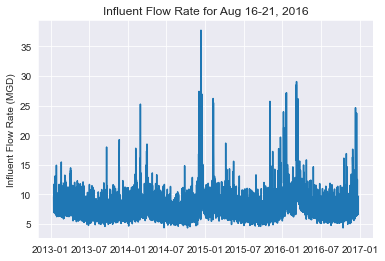

In [3]:
%matplotlib tk

sns.set_style(style="darkgrid")

color = 'tab:blue'
#plt.set_xlabel('Timestamp')
plt.ylabel('Influent Flow Rate (MGD)')
plt.plot(flow['Date'], flow['INF_FLOW'], color=color)
plt.title("Influent Flow Rate for Aug 16-21, 2016")

plt.show()

Create violin plots by month and hour:

In [4]:
# Extract months and hours (as integers) from the timestamps
flow['month'] = flow['Date'].dt.month
flow['hour'] = flow['Date'].dt.hour

# Create lookup dict for monthly names
month_look_up = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May',
            6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# Convert monthly integers into names
flow['month'] = flow['month'].apply(lambda x: month_look_up[x])

Monthly Violin Plots (save for presentation.)

Text(0, 0.5, 'Influent Flow Rate (MGD)')

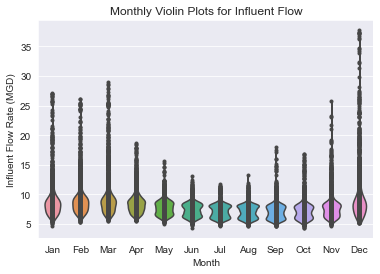

In [5]:
%matplotlib tk

# Create monthly violin plots in Seaborn
sns.set_style(style="darkgrid")

violin = sns.violinplot(y='INF_FLOW',x='month',data=flow, inner="points", orient="v",cut=0)
violin.set_title('Monthly Violin Plots for Influent Flow')
violin.set_xlabel('Month')
violin.set_ylabel('Influent Flow Rate (MGD)')

Hourly Violin Plots (the important information from this plot has already been captured in the flow line chart, and is not needed for the presentation.)

Text(0, 0.5, 'Influent Flow Rate (MGD)')

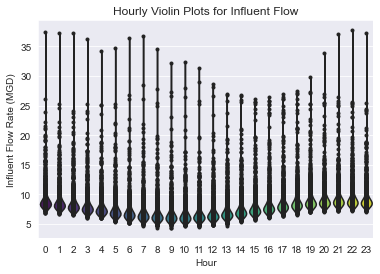

In [7]:
# Hourly violin plots

sns.set_style(style="darkgrid")

violin = sns.violinplot(y='INF_FLOW',x='hour',data=flow, inner="points", orient="v",palette='viridis',cut=0)
violin.set_title('Hourly Violin Plots for Influent Flow')
violin.set_xlabel('Hour')
violin.set_ylabel('Influent Flow Rate (MGD)')

### San Francisquito Creek Data

In [8]:
# Load creek data
creek = pd.read_table(
    'usgs_san_francisquito.txt',
    sep='\t',
    engine='python',
    skiprows=lambda x: x in range(0,30),
    header=0
    #lineterminator='\r\n'
)

# Drop column-definition row.
creek = creek.drop(0)

# Format datetime column and float datatypes, and rename columns.
creek['Date'] = pd.to_datetime(creek['datetime'],format='%Y-%m-%d %H:%M:%S')
creek = creek.astype({'14747_00060':'float64','14748_00065':'float64'})
creek = creek.rename(columns={'14747_00060':'discharge_cfs','14748_00065':'gauge_height_ft'})

# Resample data by hour and max value
creek = creek.set_index('Date').resample('H')['discharge_cfs','gauge_height_ft'].max().reset_index()

creek.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44896 entries, 0 to 44895
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             44896 non-null  datetime64[ns]
 1   discharge_cfs    44697 non-null  float64       
 2   gauge_height_ft  44720 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.0 MB


There are 100-200 nulls in the San Francisquitio Creek data, some of which occur during rain events. Simply imputing the missing data points with the mean or mode wouldn't be the most accurate approach, and since a time series model isn't being used anyway, order of the data need not be preserved. Drop these nulls for now.

In [9]:
creek = creek.dropna()

### Weather Data

In [10]:
# Load weather data

weather = pd.read_csv(
    'weather.csv',
    parse_dates=['Date']
)

weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44784 entries, 0 to 44783
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             44784 non-null  datetime64[ns]
 1   rain             44784 non-null  float64       
 2   snow             44784 non-null  float64       
 3   accum            44784 non-null  float64       
 4   temp             44784 non-null  float64       
 5   humidity         44784 non-null  float64       
 6   cloud            44784 non-null  float64       
 7   app_temperature  44784 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 2.7 MB


### Merging Datasets

Before merging, print the start & end times for all three dataframes:

In [11]:
# Print start/end times for all three dataframes
print("Flow Start Date: " + str(flow['Date'].min()))
print("Flow End Date: " + str(flow['Date'].max()))
print("Weather Start Date: " +str(weather['Date'].min()))
print("Weather End Date: " +str(weather['Date'].max()))
print("Creek Start Date: " +str(creek['Date'].min()))
print("Creek End Date: " +str(creek['Date'].max()))

Flow Start Date: 2013-01-15 00:00:00
Flow End Date: 2016-12-22 23:00:00
Weather Start Date: 2012-12-15 08:00:00
Weather End Date: 2018-01-24 07:00:00
Creek Start Date: 2013-01-01 00:00:00
Creek End Date: 2018-02-14 15:00:00


Now merge the dataframes, extract the month and hour as integers from the timestamp column, and use these integers to create circular representations based on unit circle coordinates as model features. Split the merged dataframe into a dataset for model building, and another for validation, referencing the above dates.

In [12]:
# Merge dataframes
dataset = flow.merge(weather,on='Date',how='outer')
dataset = dataset.merge(creek,on='Date',how='inner')

# Create day of week, month, and hour integer columns
dataset['month'] = dataset['Date'].dt.month
dataset['hour'] = dataset['Date'].dt.hour + 1

# Create unit circle coordinates for hour
dataset['hour_x'] = np.sin(2.*np.pi*(dataset.hour/24))
dataset['hour_y'] = np.cos(2.*np.pi*(dataset.hour/24))

# Create unit circle coordinates for month
dataset['month_x'] = np.sin(2.*np.pi*(dataset.month/12))
dataset['month_y'] = np.cos(2.*np.pi*(dataset.month/12))

# Filter by date to create separate dataframes for train/testing and validation
dataset = dataset[dataset['Date'] >= '2013-01-15 00:00:00']

validation = dataset[
    (dataset['Date'] > '2016-12-22 23:00:00') & 
    (dataset['Date'] <= '2018-01-24 07:00:00')
]

validation = validation.drop(['INF_FLOW'],axis=1)

dataset = dataset[dataset['Date'] <= '2016-12-22 23:00:00']

Four hours were skipped over in the original weather data, and appear as nulls in the merged dataframe:

In [13]:
dataset[dataset.isna().any(axis=1)]

,Date,INF_FLOW,month,hour,rain,snow,accum,temp,humidity,cloud,app_temperature,discharge_cfs,gauge_height_ft,hour_x,hour_y,month_x,month_y
7019,2013-11-03 09:00:00,5.885138,11,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.67,0.27,0.5,-0.866025,-0.5,0.866025
15637,2014-11-02 09:00:00,8.651248,11,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,0.21,0.5,-0.866025,-0.5,0.866025
24375,2015-11-01 09:00:00,5.408212,11,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.08,0.5,-0.866025,-0.5,0.866025
33173,2016-11-06 09:00:00,6.295970,11,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.81,0.30,0.5,-0.866025,-0.5,0.866025


So drop these nulls and proceed.

In [14]:
dataset = dataset.dropna()

Sweetviz is a package still in beta which enables interactive exploratory data analysis with just a single line of code. The output is saved to an HTML file in the project folder.

In [11]:
# Run SweetViz report
eda_report = sv.analyze(dataset)

Plot Creek and Rainfall data for the presentation:

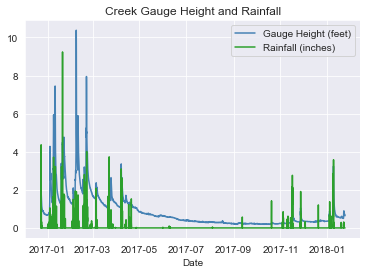

In [16]:
sns.set_style(style="darkgrid")

line1, = plt.plot(validation['Date'], validation['gauge_height_ft'], color='steelblue',label="Gauge Height (feet)")
line2, = plt.plot(validation['Date'], validation['rain'], color='tab:green',label="Rainfall (inches)")
plt.title("Creek Gauge Height and Rainfall")
plt.legend(handles=[line1,line2])
plt.xlabel('Date')
plt.savefig("creek_rainfall.png")

Is rain a lagging indicator for creek and influent flow data?

In [18]:
# Select Influent flow, rain, and creek data
data_lag = dataset.loc[:,['INF_FLOW','gauge_height_ft','discharge_cfs','rain']]

# Create columns for rain lags
data_lag['rain_l1'] = data_lag.rain.shift(periods=-1)
data_lag['rain_l2'] = data_lag.rain.shift(periods=-2)
data_lag['rain_l3'] = data_lag.rain.shift(periods=-3)

# Calculate pair-wise correlations
data_lag.corr()

,INF_FLOW,gauge_height_ft,discharge_cfs,rain,rain_l1,rain_l2,rain_l3
INF_FLOW,1.000000,0.719772,0.577496,0.420321,0.373969,0.334685,0.299678
gauge_height_ft,0.719772,1.000000,0.786941,0.389683,0.396644,0.399606,0.397352
discharge_cfs,0.577496,0.786941,1.000000,0.422429,0.438434,0.448840,0.449597
rain,0.420321,0.389683,0.422429,1.000000,0.790847,0.587476,0.464474
rain_l1,0.373969,0.396644,0.438434,0.790847,1.000000,0.790847,0.587476
rain_l2,0.334685,0.399606,0.448840,0.587476,0.790847,1.000000,0.790846
rain_l3,0.299678,0.397352,0.449597,0.464474,0.587476,0.790846,1.000000


It seems there isn't much of a time dependency between influent flow and rain, but rainfall 2-3 hours prior correlates more strongly with creek gauge height and discharge flow than concurrent rain.

# Model Training

### Split data into training & test tests

In [19]:
# Display all variables for feature selection
dataset.columns

Index(['Date', 'INF_FLOW', 'month', 'hour', 'rain', 'snow', 'accum', 'temp',
       'humidity', 'cloud', 'app_temperature', 'discharge_cfs',
       'gauge_height_ft', 'hour_x', 'hour_y', 'month_x', 'month_y'],
      dtype='object')

In [20]:
# Select specific features to use in model, otherwise all will be used
data = dataset

# Split into train/test data
train, test = sklearn.model_selection.train_test_split(data, test_size =0.25)

# Create separate dataframes for features and target variable
Xtrain = train.drop(columns=['Date','INF_FLOW'],axis=1)
Xtest = test.drop(columns=['Date','INF_FLOW'],axis=1)

Ytrain = train[['INF_FLOW']]
Ytest = test[['INF_FLOW']]

# Load these dataframes into XGBoost DMatrices for training and evaluation
Dtrain = xgb.DMatrix(Xtrain,Ytrain)
Dtest = xgb.DMatrix(Xtest,Ytest)

### Define Hyperparameters and train model

In [21]:
# Leave hyperparameters at default settings for now
config = {
    "verbosity":1,
    "objective": "reg:squarederror",
    "eval_metric": 'rmse'
}

model = xgb.train(config,Dtrain,num_boost_round=300,early_stopping_rounds=10,evals=[(Dtest,'eval')],verbose_eval=True)

[0]	eval-rmse:5.47399
Will train until eval-rmse hasn't improved in 10 rounds.
[1]	eval-rmse:3.90149
[2]	eval-rmse:2.82671
[3]	eval-rmse:2.10449
[4]	eval-rmse:1.63366
[5]	eval-rmse:1.33851
[6]	eval-rmse:1.16198
[7]	eval-rmse:1.06337
[8]	eval-rmse:1.00656
[9]	eval-rmse:0.97722
[10]	eval-rmse:0.95642
[11]	eval-rmse:0.94628
[12]	eval-rmse:0.93953
[13]	eval-rmse:0.93568
[14]	eval-rmse:0.93185
[15]	eval-rmse:0.92923
[16]	eval-rmse:0.92632
[17]	eval-rmse:0.92522
[18]	eval-rmse:0.91906
[19]	eval-rmse:0.91868
[20]	eval-rmse:0.91721
[21]	eval-rmse:0.91569
[22]	eval-rmse:0.91467
[23]	eval-rmse:0.91511
[24]	eval-rmse:0.91346
[25]	eval-rmse:0.91161
[26]	eval-rmse:0.90734
[27]	eval-rmse:0.90675
[28]	eval-rmse:0.90561
[29]	eval-rmse:0.90226
[30]	eval-rmse:0.90143
[31]	eval-rmse:0.90069
[32]	eval-rmse:0.90060
[33]	eval-rmse:0.90031
[34]	eval-rmse:0.90056
[35]	eval-rmse:0.90045
[36]	eval-rmse:0.90136
[37]	eval-rmse:0.90079
[38]	eval-rmse:0.89989
[39]	eval-rmse:0.89920
[40]	eval-rmse:0.89954
[41]	eval-

Plot model feature importances:

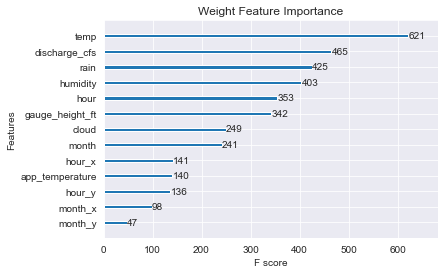

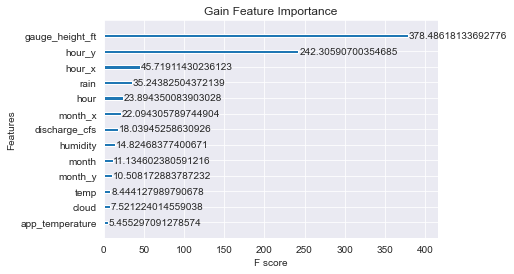

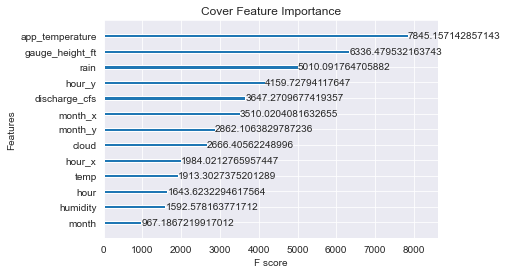

In [22]:
xgb.plot_importance(model,importance_type='weight',title="Weight Feature Importance")
xgb.plot_importance(model,importance_type='gain',title="Gain Feature Importance")
xgb.plot_importance(model,importance_type='cover',title="Cover Feature Importance")

# Graphical Model Evaluation

Run the model on the validation dataset and plot against rainfall. Add to the presentation.

In [28]:
# Create XGB DMatrix from Validation Dataframe
val_df = validation.drop(['Date'],axis=1)
val_df = xgb.DMatrix(val_df)

# Run predictions on Validation set
predictions = model.predict(val_df)
validation['predictions'] = predictions

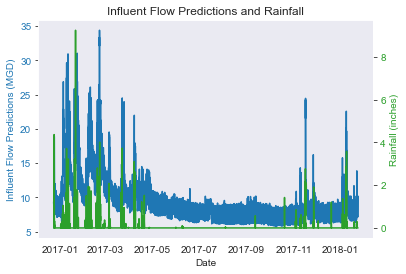

In [29]:
sns.set_style(style="dark")

fig, ax1 = plt.subplots()

teal = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Influent Flow Predictions (MGD)', color=teal)
ax1.plot(validation['Date'], validation['predictions'], color=teal)
ax1.tick_params(axis='y', labelcolor=teal)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

green = 'tab:green'
ax2.set_ylabel('Rainfall (inches)', color=green)  # we already handled the x-label with ax1
ax2.plot(validation['Date'], validation['rain'], color=green)
ax2.tick_params(axis='y', labelcolor=green)

plt.title("Influent Flow Predictions and Rainfall")
plt.savefig("pred_rain.png")

Run the model on the full dataset to plot actuals against predictions.

In [ ]:
# Create X and Y dataframes from full dataset and create XGBoost DMatrix
X = dataset.drop(columns=['Date','INF_FLOW'],axis=1)
Y = dataset[['INF_FLOW']]

Dfull = xgb.DMatrix(X,Y)

# Run predictions
predictions = model.predict(Dfull)

Create an interactive, pop-out plot with the 'tk' decorator, and zoom into the same week as the previous. Save the graphic for the presentation.

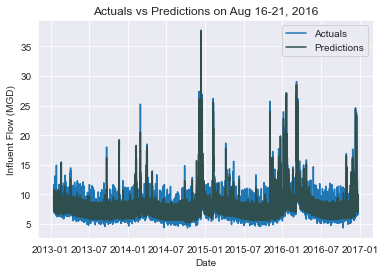

In [24]:
%matplotlib tk

sns.set_style(style="darkgrid")

line1, = plt.plot(dataset['Date'], dataset['INF_FLOW'], color='tab:blue',label="Actuals")
line2, = plt.plot(dataset['Date'], predictions, color='darkslategrey',label="Predictions")
plt.title("Actuals vs Predictions on Aug 16-21, 2016")
plt.legend(handles=[line1,line2])
plt.ylabel('Influent Flow (MGD)')
plt.xlabel('Date')

plt.show()

It seems the model often underpredicts. Run model on test dataset and calculate residuals:

In [26]:
# Run model on test dataset and calculate residuals
predictions = model.predict(Dtest)
residuals = predictions - Ytest['INF_FLOW']

Create histogram for residuals, zoom in as needed, and add to presentation:

[]

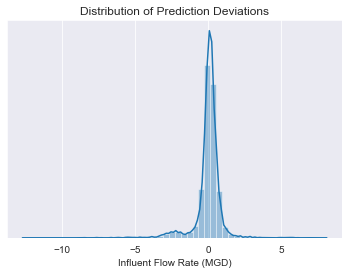

In [27]:
%matplotlib tk

sns.set_style('darkgrid')

resid_hist = sns.distplot(residuals,norm_hist=True)

resid_hist.set_title("Distribution of Prediction Deviations")
resid_hist.set_xlabel('Influent Flow Rate (MGD)')

#remove tickmarks from y-axis
resid_hist.get_yaxis().set_ticks([])

That little bump around -2 to -3 MGD reflects the intermittent spikes the model is not capturing. Add a prediction interval to the model plot and recommend it in the presentation.

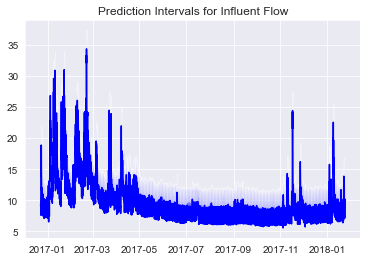

In [31]:
%matplotlib tk

sns.set_style(style="darkgrid")

plt.plot(validation['Date'], validation['predictions'], color='blue')

interval = validation['predictions'] + 3
plt.fill_between(validation['Date'], validation['predictions'], interval, facecolor='blue',alpha=0.5)
plt.title("Prediction Intervals for Influent Flow")
plt.show()

The model looks good, so save it in JSON format.

In [23]:
model.save_model('flow_model.json')

And that's it! A few other methods were attempted such as an Augmented Dicky-Fuller test for time series stationarity and Granger Causality tests, but ultimately proved unnecessary. Normally the model hyperparameters would also be optimized via cross-validation (preferably with an algorithm such as Asynchronous Hyperband Scheduling), but with this prediction interval approach, the performance of the default XGBoost parameters proved more than adequate!